In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from dwave.system import LeapHybridCQMSampler
from dimod import ConstrainedQuadraticModel, Binary

In [2]:
# Load the data
data = pd.read_csv('Dyadic_COW_4.0.csv')

# calculate the percentage change in "flow1"
data['flow1_pct_change'] = data.groupby('ccode1')['flow1'].pct_change()

# take only the rows for the year 2014
data_2014 = data[data['year'] == 2014]

# remove the rows where the percentage change is NaN
data_2014 = data_2014.dropna(subset=['flow1_pct_change'])

# remove useless variables
data_2014 = data_2014.drop(columns=['year', 'flow1', 'flow2', 'smoothflow1', 'smoothflow2', 'smoothtotrade', 'spike1', 'spike2', 'dip1', 'dip2', 'trdspike', 'tradedip', 'bel_lux_alt_flow1', 'bel_lux_alt_flow2', 'china_alt_flow1', 'china_alt_flow2', 'source1', 'source2', 'version' ])

# remove rows having "flow1_pct_change" NaN or infinite
data_2014 = data_2014[~data_2014['flow1_pct_change'].isnull()]
data_2014 = data_2014[~data_2014['flow1_pct_change'].isin([np.inf, -np.inf])]

# remove duplicate rows
data_2014 = data_2014.drop_duplicates()

In [3]:
# Create an empty directed graph
G = nx.Graph()

# Add edges to the graph
for idx, row in data_2014.iterrows():
    G.add_edge(row["ccode1"], row["ccode2"], weight=row["flow1_pct_change"])

# Draw the graph
# Get positions for the nodes in the graph
pos = nx.spring_layout(G)

In [4]:
# create a dictionary between country codes and country names
ccodes = data_2014['ccode1'].unique()
cnames = data_2014['importer1'].unique()

ccode_dict = dict(zip(ccodes, cnames))
ccode_dictReversed  = {v: k for k, v in ccode_dict.items()}

In [5]:
# print the number of nodes
print(len(G.nodes))

195


C:\Users\lino\AppData\Local\Temp\ipykernel_10692\657946924.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121, title="Positive Edges")


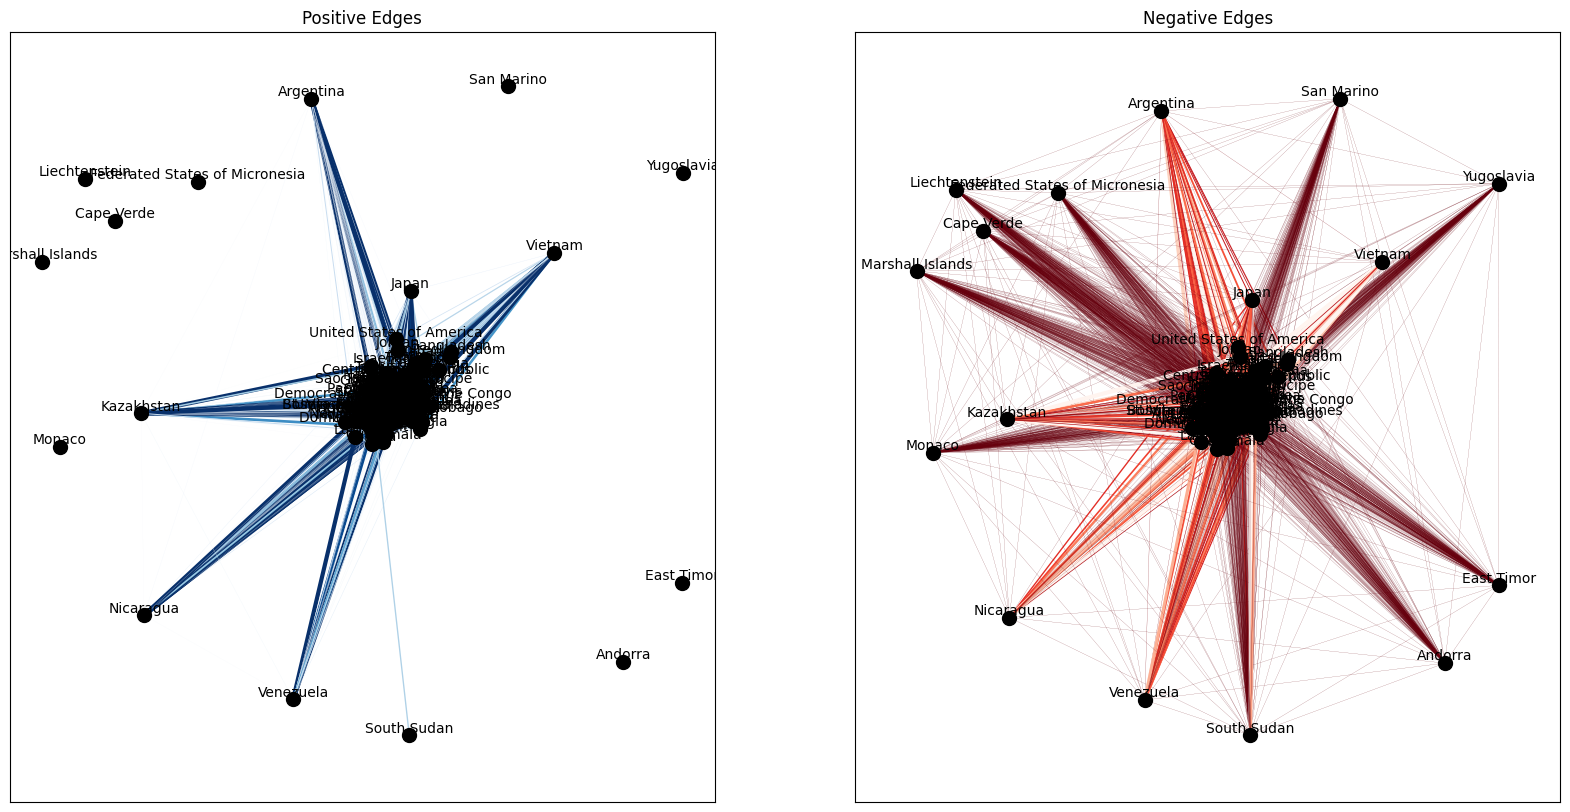

In [6]:
# Draw the graph in 2 separate subplots, one for positive weights and one for negative weights
plt.figure(figsize=(20, 10))
plt.title("Graph Representation of DataFrame")

# edge color and edge width should be based on the weight of the edge. The higher the weight, the darker the edge color and the thicker the edge. Except for the edges with negative weights, they should be colored red.

# Separate the edges based on weight
positive_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] > 0]
negative_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] <= 0]

# Get weights for edges
positive_weights = [G[u][v]['weight'] for u, v in positive_edges]
negative_weights = [G[u][v]['weight'] for u, v in negative_edges]

# set the maximum and minimum weight to +1 and -1
positive_weights = [min(weight, 1) for weight in positive_weights]
negative_weights = [max(weight, -1) for weight in negative_weights]

# First subplot
plt.subplot(121, title="Positive Edges")

# Draw positive edges
nx.draw_networkx_edges(
    G, pos,
    edgelist=positive_edges,
    width=[max(0.1, abs(weight)*3) for weight in positive_weights],  # Adjust the scaling factor for weights
    edge_color=positive_weights,
    edge_cmap=plt.cm.Blues,
    edge_vmin=0, edge_vmax=max(positive_weights)
)
# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_color='black', node_size=100)
# draw node labels on the graph. And move the labels a little bit away from the nodes 
nx.draw_networkx_labels(G, pos, font_size=10, labels=ccode_dict, font_color='black', verticalalignment='bottom')

# second subplot
plt.subplot(122, title="Negative Edges")

# Draw negative edges
nx.draw_networkx_edges(
    G, pos,
    edgelist=negative_edges,
    width=[max(0.1, abs(weight)*3) for weight in negative_weights],  # Adjust the scaling factor for weights
    edge_color=negative_weights,
    edge_cmap=plt.cm.Reds,
    edge_vmin=min(negative_weights), edge_vmax=0
)
nx.draw_networkx_nodes(G, pos, node_color='black', node_size=100)

# draw node labels on the graph. And move the labels a little bit away from the nodes 
nx.draw_networkx_labels(G, pos, font_size=10, labels=ccode_dict, font_color='black', verticalalignment='bottom')

# Show the plot
plt.savefig("graph.png")
plt.show()

In [7]:
# create a method to remove a node from the graph and his edges
def remove_node(G, node):
    # remove the node from the graph
    G.remove_node(node)

In [8]:
# list of removable nodes
list = ["San Marino", "East Timor", "Monaco", "Yugoslavia", "Andorra", "Cape Verde", "Marshall Islands", "Vietnam", "Sao Tome and Principe", "Kiribati", "Tuvalu", "Nauru", "Palau", "Solomon Islands", "Vanuatu", "Comoros", "Seychelles", "Mauritius", "Maldives", "Liechtenstein", "Federated States of Micronesia", "Vietnam", "Liechtenstein", "South Sudan", "Kazakhstan", "Venezuela", "Nicaragua"]

# list of foundamental nodes
f_list = ["United States of America", "Italy", "Germany", "Canada", "China", "Russia", "Japan", "Brazil", "India", "France", "United Kingdom", "Australia", "Spain", "Mexico", "South Korea", "Netherlands", "Turkey", "Saudi Arabia", "Indonesia", "Switzerland", "Sweden", "Norway", "Denmark", "Finland", "Belgium", "Austria", "Poland", "Czech Republic", "Portugal", "Greece", "Ireland", "Hungary", "Romania", "Bulgaria", "Croatia", "Slovenia", "Slovakia", "Estonia", "Latvia", "Lithuania", "Cyprus", "Malta", "Luxembourg", "Iceland", "New Zealand", "Singapore", "Taiwan", "South Africa", "Argentina", "Chile", "Colombia", "Peru", "Thailand", "Philippines", "Malaysia"]

In [9]:
# keep only the nodes that are in the list and remove the others
nodesToKeep = []
nodesToRemove = []
for node in f_list:
    node = ccode_dictReversed[node]
    nodesToKeep.append(node)

In [10]:
# iterate over the nodes and remove the ones that are not in the list
for node in G.nodes:
    if node not in nodesToKeep:
        nodesToRemove.append(node)

# remove nodes
for node in nodesToRemove:
    try:
        remove_node(G, node)
    except:
        pass

15245
15100
14925
14800
14663
14531
14403
14300
14174
14050
13898
13758
13643
13520
13402
13267
13116
12954
12819
12689
12550
12420
12286
12140
12007
11884
11716
11549
11383
11218
11101
10964
10830
10669
10524
10378
10246
10098
9966
9832
9714
9596
9444
9339
9242
9135
9036
8923
8793
8688
8579
8483
8363
8252
8168
8075
7976
7863
7774
7664
7540
7437
7343
7245
7153
7054
6944
6824
6713
6637
6546
6473
6383
6282
6188
6091
5998
5916
5831
5731
5644
5560
5469
5378
5300
5206
5115
5015
4917
4820
4732
4640
4540
4450
4366
4277
4191
4100
4015
3934
3869
3785
3705
3617
3533
3458
3386
3308
3236
3164
3088
3014
2945
2883
2805
2735
2667
2594
2532
2462
2389
2324
2265
2212
2142
2087
2045
2005
1966
1914
1883
1843
1781
1720
1681
1626
1587
1545
1505
1485


In [13]:
# Define the number of clusters
num_clusters = 3  # You can change this to 4 or another number

# Create binary variables for each node and each cluster
cqm = ConstrainedQuadraticModel()
node_cluster_vars = {node: [Binary(f'x_{node}_{cluster}') for cluster in range(num_clusters)] for node in G.nodes}

# Add constraints to ensure each node is assigned to exactly one cluster
for node, vars in node_cluster_vars.items():
    cqm.add_constraint(sum(vars) == 1, label=f'one_cluster_{node}')

# Add the objective function to maximize intra-cluster similarity and minimize inter-cluster similarity
objective = 0
for u, v, data in G.edges(data=True):
    weight = data['weight']
    for i in range(num_clusters):
        # Nodes in the same cluster
        objective += weight * node_cluster_vars[u][i] * node_cluster_vars[v][i]
        # Nodes in different clusters
        for j in range(i+1, num_clusters):
            objective -= weight * node_cluster_vars[u][i] * node_cluster_vars[v][j]
            objective -= weight * node_cluster_vars[u][j] * node_cluster_vars[v][i]

cqm.set_objective(objective)

# Solve the problem
sampler = LeapHybridCQMSampler(token="DEV-c656c45b76fe02df536f0ce348eb602bcab9f1de")
sampleset = sampler.sample_cqm(cqm)

# Get the best solution
best_solution = sampleset.first.sample

# Print the clusters
clusters = {i: [] for i in range(num_clusters)}
for node in G.nodes:
    for i in range(num_clusters):
        if best_solution[f'x_{node}_{i}']:
            clusters[i].append(node)

print("Clusters: ", clusters)

# Convert clusters to country names
clusters_named = {i: [ccode_dict[node] for node in cluster] for i, cluster in clusters.items()}
print("Named Clusters: ", clusters_named)

KeyboardInterrupt: 

In [33]:
# check cluster length
for i in range(num_clusters):
    print(len(clusters_named[i]))

26
22
25


In [34]:
# Ensure each nation is in only one cluster
seen_nodes = set()
for i in range(num_clusters):
    clusters[i] = [node for node in clusters[i] if node not in seen_nodes]
    seen_nodes.update(clusters[i])

# Check if any nodes are missing from all clusters
all_nodes = set(G.nodes)
missing_nodes = all_nodes - seen_nodes
if missing_nodes:
    print(f"Warning: These nodes were not assigned to any cluster: {missing_nodes}")
    # Assign missing nodes to the smallest cluster
    smallest_cluster = min(clusters, key=lambda k: len(clusters[k]))
    clusters[smallest_cluster].extend(missing_nodes)

print("Clusters after ensuring uniqueness: ", clusters)

Clusters after ensuring uniqueness:  {0: [2, 20, 70, 100, 135, 160, 200, 290, 344, 349, 355, 365, 366, 367, 380, 640, 670, 710, 732, 740, 800, 820, 840, 850, 900, 920], 1: [155, 205, 210, 212, 310, 316, 338, 360, 368, 375, 390, 395, 713, 750, 830], 2: [140, 211, 220, 225, 230, 235, 255, 305, 317, 325, 350, 352, 385, 560]}


In [38]:
# check cluster length
tot = 0
for i in range(num_clusters):
    print(len(clusters[i]))
    tot += len(clusters[i])
print("Total number of elements: ",tot)

26
15
14
Total number of elements:  55


In [2]:
best_solution = {0: ['United States of America', 'Canada', 'Colombia', 'Peru', 'Argentina', 'United Kingdom', 'Poland', 'Hungary', 'Czech Republic', 'Croatia', 'Slovenia', 'Bulgaria', 'Russia', 'Estonia', 'Latvia', 'Lithuania', 'Finland', 'Denmark', 'Turkey', 'China', 'Taiwan', 'Japan', 'India', 'Thailand', 'Malaysia', 'Singapore', 'Philippines', 'Indonesia', 'Australia', 'New Zealand'], 1: ['Mexico', 'Colombia', 'Chile', 'Ireland', 'Netherlands', 'Belgium', 'Luxembourg', 'Portugal', 'Hungary', 'Czech Republic', 'Slovakia', 'Italy', 'Malta', 'Romania', 'Estonia', 'Latvia', 'Lithuania', 'Finland', 'Denmark', 'Iceland', 'Taiwan', 'Malaysia', 'Singapore'], 2: ['Canada', 'Mexico', 'Chile', 'Netherlands', 'Belgium', 'Luxembourg', 'France', 'Switzerland', 'Spain', 'Portugal', 'Germany', 'Poland', 'Austria', 'Slovakia', 'Italy', 'Malta', 'Slovenia', 'Greece', 'Cyprus', 'Bulgaria', 'Russia', 'Sweden', 'Norway', 'Iceland', 'South Africa', 'Saudi Arabia', 'South Korea', 'Thailand', 'Philippines', 'Indonesia']}

In [6]:
# plot the results of the "best_solution"
plt.figure(figsize=(20, 10))
plt.title("Graph Representation of DataFrame")
# edge color and edge width should be based on the weight of the edge. The higher the weight, the darker the edge color and the thicker the edge. Except for the edges with negative weights, they should be colored red.
